### EASILY CUSTOMIZABLE AUTOENCODERS
- 6. feb. 2025
#### Will be moved to **architectures** once finished

In [205]:
# from ...DementiaMRI.Architectures.VAE import VAE
from Data.load import load
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from Metrics.metrics import NMSE, SSIM
import glob

import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input, activations, regularizers
import tensorflow.keras.backend as K

import time

In [3]:
# WILL MOST LIKELY BE ADDED LATER

# Conv Block
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, ch_in, ch_out, k_size, stride=1, p=1, num_groups=1):
        super(ConvBlock, self).__init__()
        self.conv = models.Sequential([
            layers.Conv3D(ch_out, kernel_size=k_size, strides=stride, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    def call(self, x):
        return self.conv(x)

# ResNet Block
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, ch, k_size, stride=1, p=1, num_groups=1):
        super(ResNetBlock, self).__init__()
        self.conv = models.Sequential([
            layers.Conv3D(ch, kernel_size=k_size, strides=stride, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv3D(ch, kernel_size=k_size, strides=stride, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])

    def call(self, x):
        return self.conv(x) + x # look skip connections, ayooo!

# Up-conv Layer
class UpConv(tf.keras.layers.Layer):
    def __init__(self, ch_in, ch_out, k_size=1, scale=2, align_corners=False):
        super(UpConv, self).__init__()
        self.up = models.Sequential([
            layers.Conv3D(ch_out, kernel_size=k_size),
            layers.UpSampling3D(size=(scale, scale, scale))
        ])

    def call(self, x):
        return self.up(x)

#### LOADING THE DATA

In [206]:
train, test = load(train_test_split=0.8)
print(train.shape, test.shape)

Loading images:   0%|          | 0/496 [00:00<?, ?it/s]

Loading images:  11%|█         | 53/496 [00:18<02:36,  2.83it/s]


MemoryError: Unable to allocate 97.5 MiB for an array with shape (208, 240, 256) and data type float64

In [3]:
class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                VAE_model=False,
                debug=False):
        super(AE, self).__init__(name=name)
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.history = None
        self.debug = debug
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        shape_changed = False
        if self.input_shape[-1] > 3:
            self.input_shape = list(self.input_shape) + [1]
            shape_changed = True
        if len(self.input_shape) > 4:
            self.input_shape = self.input_shape[-4:]
            shape_changed = True
        if shape_changed:
            print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")
        
        # - Add encoder layers
        for layer in self.encoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
            
            print(f"After {x.shape}: {layer}") if self.debug else None

        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)
        x = layers.Dense(self.latent_dim, activation="relu")(x)
        self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model
        latent_input = x = layers.Input(shape=x.shape[1:])  # Latent input
        
        # Calculate the expected target shape after decoder layers
        target_shape = pre_flatten_shape[1:]

        # Reshape the latent vector back to the original spatial dimensions
        x = layers.Dense(np.prod(target_shape), activation="relu")(latent_input)
        x = layers.Reshape(target_shape)(x)

        # - Add decoder layers
        for layer in self.decoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
        self.decoder = Model(latent_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full autoencoder
        autoencoder_output = self.decoder(self.encoder(input_layer))
        self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        self.autoencoder.compile(optimizer='adam', loss='mse')

    def summary(self):
        """Print a summary of the neural network model."""
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False):
        print(f"Training {self.name}", end="")
        start_time = time.time()
        self.history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2,
            verbose=verbose
        )
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history
    
    #def sample2(mu, logvar):
    #    batch = tf.shape(mu)[0]
    #    dim = tf.shape(mu)[1]
    #    epsilon = tf.random.normal(shape=(batch, dim))
    #    return mu + tf.exp(0.5 * logvar) * epsilon

    def sample(self, mean, log_var):
        """Sample from the latent space distribution using the reparameterization trick."""
        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mean))  # Sample epsilon from N(0, 1)
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization
        return z

    def plot_evaluation(self):
        """Plot the training and validation accuracy/loss over epochs using training logs."""
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

    def save(self, path, name="AE"):
        """Save the autoencoder, encoder, and decoder models to disk."""
        os.makedirs(path, exist_ok=True)
        self.autoencoder.save(os.path.join(path, f"{name}_autoencoder.keras"))
        self.encoder.save(os.path.join(path, f"{name}_encoder.keras"))
        self.decoder.save(os.path.join(path, f"{name}_decoder.keras"))
        print(f"Models saved to {path} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

    @staticmethod
    def open(path, name="AE"):
        """Load the autoencoder, encoder, and decoder models from disk."""
        autoencoder_path = os.path.join(path, f"{name}_autoencoder.keras")
        encoder_path = os.path.join(path, f"{name}_encoder.keras")
        decoder_path = os.path.join(path, f"{name}_decoder.keras")

        if not (os.path.exists(autoencoder_path) and os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Could not find models in {path}. Ensure the correct name is used.")

        autoencoder = tf.keras.models.load_model(autoencoder_path)
        encoder = tf.keras.models.load_model(encoder_path)
        decoder = tf.keras.models.load_model(decoder_path)

        # Create an instance of AE without initializing
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Set required attributes
        ae.name = name
        ae.built = True
        ae.history = None
        ae.debug = False

        # Compile the loaded model manually
        ae.autoencoder.compile(loss='mean_squared_error', optimizer='adam')

        print("Models loaded and compiled successfully.")
        return ae


In [ ]:
def plot_models_training_time(models_list, fig_size=""):
    training_times = []
    names = []
    for m in models_list:
        if hasattr(m, 'training_time') and m.training_time is not None:
            training_times.append(m.training_time)
            names.append(m.name)

    if training_times:
        if fig_size: 
            plt.figure(figsize=fig_size)
        plt.bar(names, training_times)
        plt.xlabel('Model index')
        plt.ylabel('Training time (seconds)')
        plt.title('Training time of models')
        plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees, align right
        plt.show()

def compare_models_loss_history(models, log10=True, fig_size="", title="Model's loss history"):
    """
    Compares the loss histories of multiple models by plotting their log-transformed losses.

    Parameters:
    - models: list of model objects, each containing a 'log.history["loss"]' attribute and a 'name'.

    Returns:
    - None: Displays a plot of the loss histories.
    """
    if fig_size: 
        plt.figure(figsize=fig_size)
    for i, model in enumerate(models):
        #color = decimal_to_rgb(i, len(models))
        #color = "#{:02x}{:02x}{:02x}".format(np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        #y = [model.history.history["loss"], np.log10(model.history.history["loss"])][log10]
        
        # Sorry for the mess, but I wanted this to work for two different classes
        if isinstance(model.history, tf.keras.callbacks.History):
            y = [model.history.history["loss"], np.log10(model.history.history["loss"])][log10]
        else:
            y = [model.history["loss"], np.log10(model.history["loss"])][log10]
        plt.plot(y, label=model.name) #, color=color
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss Log10") if log10 else plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def plot_images(images, dimensions, fig_size=(10,8), titles=[], top_title="Image Gallery", cmap="viridis"):
    """
    Plots a grid of images with corresponding titles.

    Parameters:
    - images: list of numpy arrays, the images to be displayed.
    - dimensions: tuple of int (rows, cols), grid layout for images.
    - fig_size: tuple for the figure size, eg (10,8)
    - titles: list of str, the titles for each image.
    - top_title: str, optional, the title of the overall figure.

    Returns:
    - None: Displays the plot.
    """
    plt.figure(figsize=fig_size)
    plt.suptitle(top_title, fontsize=12, fontweight="bold", y=0.99)
    for i, img in enumerate(images):
        plt.subplot(dimensions[0], dimensions[1], i + 1)
        plt.imshow(img, cmap=cmap)
        if len(titles) == len(images):
            plt.title(titles[i], fontsize=10)
        plt.axis('off')
        plt.tight_layout()
    plt.show()

def compare_models_reconstruction(brain_scan_id, models_list):
    images = []
    for m in models_list:
        recon = m.decode(m.encode(test))
        input_image = np.rot90(test[brain_scan_id][40].reshape((96, 80)))
        recon_image = np.rot90(recon[brain_scan_id][40])[:,:,0] # recon shape is 3dim we need -> 2d
        images.append(input_image)
        images.append(recon_image)
        images.append(input_image - recon_image)
    return images

In [ ]:
# Custom version of keras.Sequential that will also allow skip connections in the future
models_list = [

    AE(name="AE (4h, 8-64f, 128L)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),
            # (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            # (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
    
    AE(name="AE (4h 8-64f, 128L, dropout)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            # (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            # (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),

    AE(name="AE (4h, 16-12f, 128L, dropout)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128,
        encoder_layers=[
            #(layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            #(layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),

    AE(name="AE (3h, 16-64f, 1024L, dropout)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128*8,
        encoder_layers=[
            #(layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            #(layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),

    AE(name="VAE (4h, 8-64f, 128L)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128*2,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
    ], VAE_model=True),

    AE(name="VAE (4h, 8-64f, 128L, dropout)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True),
    
    AE(name="VAE (4h, 16-128f, 128L, dropout)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
    
    AE(name="AE (3h, 8-32f, 258L, dropout)",
        input_shape=train.shape,
        latent_dim=256,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
    
    # SIMILAR VAE TO THE TEACHER MAIL TIP, BUT WITHOUT SKIP CONNECTIONS 
    AE(name="AE (4h, 16-128f, 128L, batchn, relu)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 32, (3,3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.MaxPooling3D, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 64, (3,3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.MaxPooling3D, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 128, (3,3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.MaxPooling3D, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 256, (3,3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.MaxPooling3D, (3,3,3), {'strides': 2, 'padding': 'same'}),
        ],
        decoder_layers=[
            (layers.Conv3D, 256, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
]


models_list = [models_list[-1]]
for i, m in enumerate(models_list): 
    #m.summary()
    m.train(train, epochs=20, batch_size=10, verbose=False)

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 128)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 128)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 32)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 256)
Training AE (4h, 16-128f, 128L, batchn, relu) on the CPU - 529.49s


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
0.16913168611874463


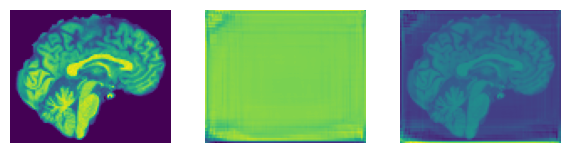

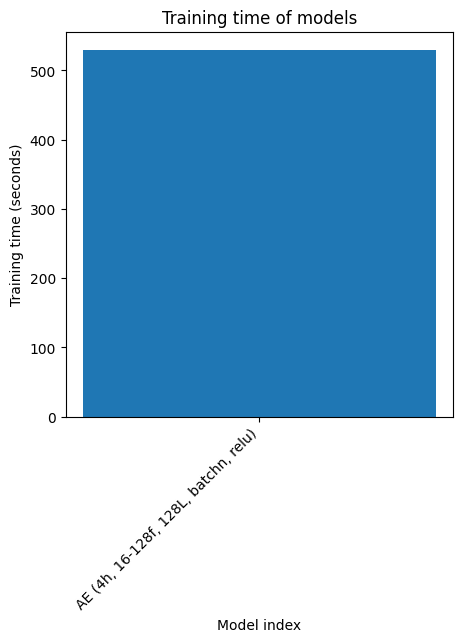

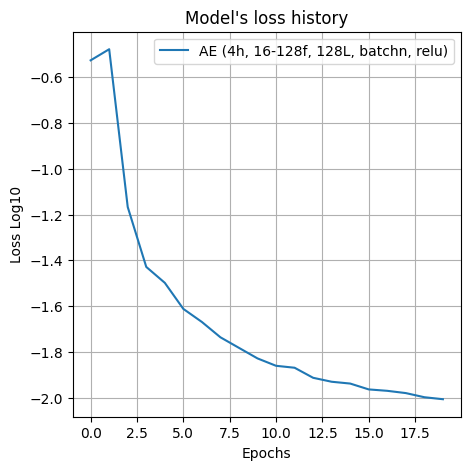

In [192]:
if 'models_list' in locals(): # if the variable exists
    images = compare_models_reconstruction(brain_scan_id=0, models_list=models_list)
    print(SSIM(images[0], images[1]))
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    plot_models_training_time(models_list, fig_size=(5,5))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))

##### Q1: Can we run keras on the GPU?
##### Q2: Can we reduce the latent space size?

In [197]:
class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                VAE_model=False,
                debug=False,
                GPU = False):
        super(AE, self).__init__(name=name)
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.history = None
        self.debug = debug
        self.GPU = GPU
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        # Ensure TensorFlow is using the GPU
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
        shape_changed = False
        if self.input_shape[-1] > 3:
            self.input_shape = list(self.input_shape) + [1]
            shape_changed = True
        if len(self.input_shape) > 4:
            self.input_shape = self.input_shape[-4:]
            shape_changed = True
        if shape_changed:
            print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")
        
        # - Add encoder layers
        for layer in self.encoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
            
            print(f"After {x.shape}: {layer}") if self.debug else None

        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)
        x = layers.Dense(self.latent_dim, activation="relu")(x)
        self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model
        latent_input = x = layers.Input(shape=x.shape[1:])  # Latent input
        
        # Calculate the expected target shape after decoder layers
        target_shape = pre_flatten_shape[1:]

        # Reshape the latent vector back to the original spatial dimensions
        x = layers.Dense(np.prod(target_shape), activation="relu")(latent_input)
        x = layers.Reshape(target_shape)(x)

        # - Add decoder layers
        for layer in self.decoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
        self.decoder = Model(latent_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full autoencoder
        autoencoder_output = self.decoder(self.encoder(input_layer))
        self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        # self.autoencoder.compile(optimizer='adam', loss='mse')

        # 4. GPU or CPU assignment (based on self.GPU)
        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            # Set device to GPU if available
            with tf.device('/GPU:0'):
                self.autoencoder.compile(optimizer='adam', loss='mse')
        else:
            # Default to CPU
            self.autoencoder.compile(optimizer='adam', loss='mse')

    def summary(self):
        """Print a summary of the neural network model."""
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100):
        start_time = time.time()        
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)

        #self.history = tf.keras.callbacks.History()  # Ensure history is initialized
        #self.history.history = {"loss": [], "val_loss": []}
        self.history = {"loss": [], "val_loss": []}
        
        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            print(f"Training {self.name} on the GPU", end="")
            with tf.device('/GPU:0'):
                for epoch in range(1, epochs + 1):
                    history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                    )
                    # self.history.history["loss"].extend(history.history["loss"])
                    # self.history.history["val_loss"].extend(history.history["val_loss"])
                    self.history["loss"].extend(history.history["loss"])
                    self.history["val_loss"].extend(history.history["val_loss"])

                    if save_path and epoch % save_interval == 0:
                        self.save(save_path, name=f"{self.name}_epoch{epoch}")
        else:
            print(f"Training {self.name} on the CPU", end="")
            for epoch in range(1, epochs + 1):
                history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                )
                #self.history.history["loss"].extend(history.history["loss"])
                #self.history.history["val_loss"].extend(history.history["val_loss"])
                self.history["loss"].extend(history.history["loss"])
                self.history["val_loss"].extend(history.history["val_loss"])
                if save_path and epoch % save_interval == 0:
                    self.save(save_path, name=f"{self.name}_epoch{epoch}")
        
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history
    
    #def sample2(mu, logvar):
    #    batch = tf.shape(mu)[0]
    #    dim = tf.shape(mu)[1]
    #    epsilon = tf.random.normal(shape=(batch, dim))
    #    return mu + tf.exp(0.5 * logvar) * epsilon

    def sample(self, mean, log_var):
        """Sample from the latent space distribution using the reparameterization trick."""
        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mean))  # Sample epsilon from N(0, 1)
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization
        return z

    def plot_evaluation(self):
        """Plot the training and validation accuracy/loss over epochs using training logs."""
        pd.DataFrame(self.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

    def save(self, path, name="AE"):
        """Save the autoencoder, encoder, and decoder models to disk."""
        os.makedirs(path, exist_ok=True)
        self.autoencoder.save(os.path.join(path, f"{name}_autoencoder.keras"))
        self.encoder.save(os.path.join(path, f"{name}_encoder.keras"))
        self.decoder.save(os.path.join(path, f"{name}_decoder.keras"))
        print(f"Models saved to {path} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

    @staticmethod
    def open(autoencoder_path):
        """Load the autoencoder, encoder, and decoder models from disk using a single path."""
        if not os.path.exists(autoencoder_path):
            raise FileNotFoundError(f"Could not find autoencoder model at {autoencoder_path}.")

        path, autoencoder_filename = os.path.split(autoencoder_path)
        name = autoencoder_filename.replace("_autoencoder.keras", "")

        encoder_path = os.path.join(path, f"{name}_encoder.keras")
        decoder_path = os.path.join(path, f"{name}_decoder.keras")

        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Could not find encoder or decoder models in {path}.")

        autoencoder = tf.keras.models.load_model(autoencoder_path)
        encoder = tf.keras.models.load_model(encoder_path)
        decoder = tf.keras.models.load_model(decoder_path)

        # Create an instance of AE without initializing
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Set required attributes
        ae.name = name
        ae.built = True
        ae.history = None
        ae.debug = False

        # Compile the loaded model manually
        ae.autoencoder.compile(loss='mean_squared_error', optimizer='adam')

        print("Models loaded and compiled successfully.")
        return ae

In [180]:
models_list2 = [

    # AE(name="AE (3h, 8-32f, 258L, dropout)",
    #     input_shape=train.shape,
    #     latent_dim=256,
    #     encoder_layers=[
    #         (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
    #         (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
    #         (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
    #     ],
    #     decoder_layers=[
    #         (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
    #         (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
    #         (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
    #         (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
    #     ], VAE_model=False, GPU=True),

    AE(name="VAE (3h, 8-32f, 1024L, dropout)",
        input_shape=train.shape,
        latent_dim=256*4,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ], VAE_model=True, GPU=True)
]


for m in models_list2: 
    m.train(train, epochs=100, batch_size=5, verbose=False)# , 
            #save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
            #save_interval=100) # saves every 100 epoch btw

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 32)
Training VAE (3h, 8-32f, 1024L, dropout) on the CPU - 442.79s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
0.3122541268100024


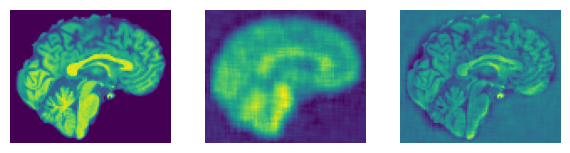

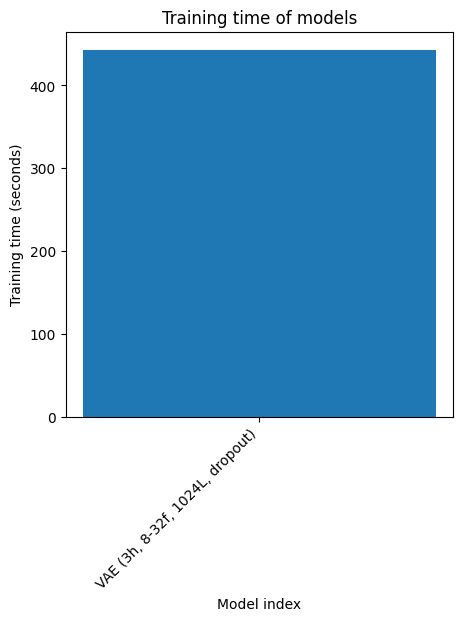

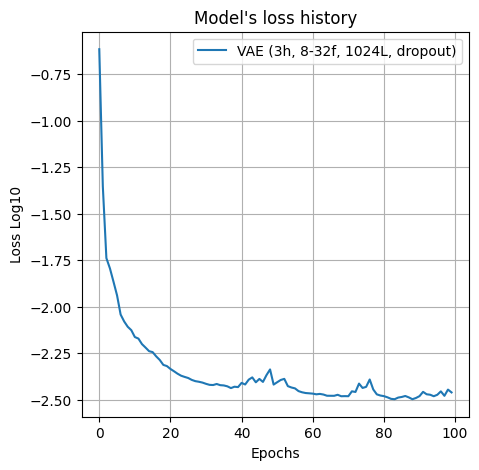

In [181]:
#models_list2[0].history
#plt.plot(np.log10(models_list2[0].history["loss"]))
#plt.plot(np.log10(models_list2[1].history["loss"]))
# images = compare_models_reconstruction(brain_scan_id=0, models_list=models_list2)
if 'models_list2' in locals(): # if the variable exists
    images = compare_models_reconstruction(brain_scan_id=0, models_list=models_list2)
    print(SSIM(images[0], images[1]))
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

    plot_models_training_time(models_list2, fig_size=(5,5))
    compare_models_loss_history(models_list2, log10=True, fig_size=(5,5))

In [ ]:
model = models_list2[0]
"""
# Sorry for the mess, but I wanted this to work for two different classes
if isinstance(model.history, tf.keras.callbacks.History):
    y = [model.history.history["loss"], np.log10(model.history.history["loss"])][log10]
else:
    print(model.history)
    y = [model.history["loss"], np.log10(model.history["loss"])][log10]
"""

'\n# Sorry for the mess, but I wanted this to work for two different classes\nif isinstance(model.history, tf.keras.callbacks.History):\n    y = [model.history.history["loss"], np.log10(model.history.history["loss"])][log10]\nelse:\n    print(model.history)\n    y = [model.history["loss"], np.log10(model.history["loss"])][log10]\n'

In [162]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2.17.0
Num GPUs Available:  0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


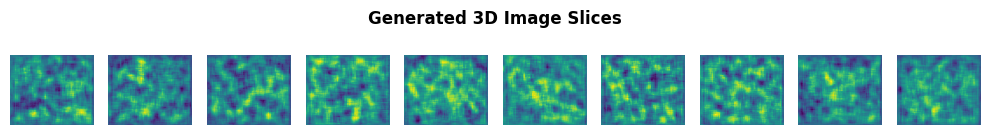

In [182]:
m = models_list2[0]
num_samples = 10
slice_index = 40

generated_volumes = m.decoder.predict(np.random.normal(size=(num_samples, m.latent_dim)))
images = [np.rot90(vol[slice_index]) for vol in generated_volumes]  # Extract a slice from each 3D volume

plot_images(images, dimensions=(5, num_samples), fig_size=(10,5), top_title="Generated 3D Image Slices")

Models loaded and compiled successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


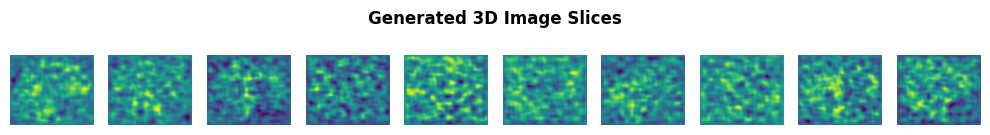

Models loaded and compiled successfully.
Models loaded and compiled successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
0.3780990027452584
0.32617519292563923


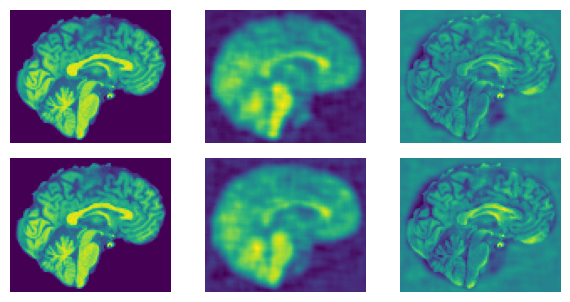

In [167]:
# Open trained model
m = AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models\VAE (3h, 8-32f, 258L, dropout)_epoch1000_autoencoder.keras")
m.latent_dim = 256 # yes you have to add this (could be saved and loaded/opened/inited by save name)
num_samples = 10
slice_index = 40

# Plot generated 3d image slices
generated_volumes = m.decoder.predict(np.random.normal(size=(num_samples, m.latent_dim)))
images = [np.rot90(vol[slice_index]) for vol in generated_volumes]  # Extract a slice from each 3D volume
plot_images(images, dimensions=(5, num_samples), fig_size=(10,5), top_title="Generated 3D Image Slices")


temp_models = [
    AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models\AE (3h, 8-32f, 258L, dropout)_epoch1000_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models\VAE (3h, 8-32f, 258L, dropout)_epoch1000_autoencoder.keras")
]


# Compare brains
images = compare_models_reconstruction(brain_scan_id=0, models_list=temp_models)
print(SSIM(images[0], images[1]))
print(SSIM(images[3], images[4]))
plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=[], top_title="")

- A1: I can only run on the CPU on keras :(
- A2: Upscaling the latent space helps, but Im getting more certain the problem is the data itself, perhaps data augmentation will help for the ae, vae we should test this

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 32)
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 620ms/step - loss: 0.1776 - val_loss: 0.0393
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - loss: 0.0455 - val_loss: 0.0418
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - loss: 0.0486 - val_loss: 0.0261
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - loss: 0.0219 - val_loss: 0.0142
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 513ms/step - loss: 0.0140 - val_loss: 0.0123
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 562ms/step - loss: 0.0123 - val_loss: 0.0077
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - loss: 0.0098 - val_loss: 0.0074
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step - loss: 0.0092 - val_loss: 0.0055
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step - loss: 0.0075 - val_loss: 0.0053
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - loss: 0.0074 - val_loss: 0.0054
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step - loss: 0.0067 - val_loss: 0.0049
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - loss: 0.0065 - val_loss: 0.0051
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 533m

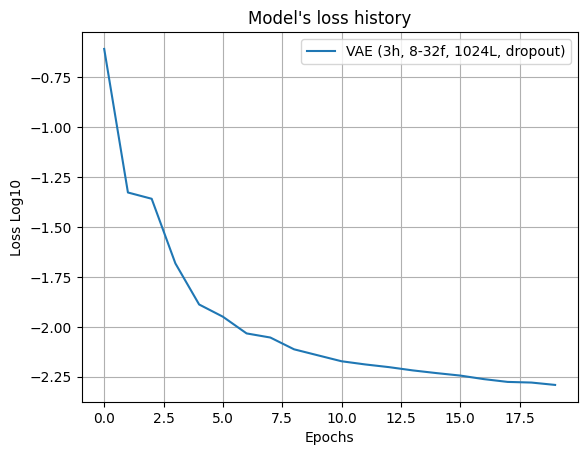

In [204]:
mod = AE(name="VAE (3h, 8-32f, 1024L, dropout)",
    input_shape=train.shape,
    latent_dim=128,
    encoder_layers=[
        (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        #(layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
    ],
    decoder_layers=[
        #(layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
    ], VAE_model=True, GPU=False)

mod.train(train, epochs=20, batch_size=5, verbose=True)
compare_models_loss_history([mod], log10=True)